## Coding Exercise #0806

In [1]:
#To enable CPU execution only
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [1]:
# Available backend options are: "jax", "tensorflow", "torch".
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

#### 1. Document classification with LSTM network:

In [2]:
import time
import pandas as pd
import numpy as np
import warnings    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets.reuters import load_data, get_word_index       # Reuters news data. 
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.optimizers import Adam, RMSprop, SGD
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data:

In [3]:
n_words = 1000                                        # Size of the vocabulary.
(X_train, y_train), (X_test, y_test) = load_data(num_words = n_words, test_split = 0.3)
n_train_size = X_train.shape[0]

In [4]:
# Check for the shapes.
print("-"*50)
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("-"*50)
print("Test data X shape: {}".format(X_test.shape))
print("Test data y shape: {}".format(y_test.shape))
print("-"*50)

--------------------------------------------------
Training data X shape: (7859,)
Training data y shape: (7859,)
--------------------------------------------------
Test data X shape: (3369,)
Test data y shape: (3369,)
--------------------------------------------------


#### 1.2. Explore the data:

In [5]:
# Number of unique values of y = Number of categories of the newswires.
n_cat = pd.Series(y_train).nunique()
n_cat

46

In [6]:
# Print out an observation (document) contained in X.
# It is encoded as integers (indices).
print(X_train[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [7]:
# Let's check for length of the first 100 documents.
# We notice that the length is not uniform.
print([len(a) for a in X_train[0:100]])

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64]


In [8]:
# Download the dictionary to translate the indices.
my_dict = get_word_index(path='reuters_word_index.json')

In [9]:
# To view the dictionary.
# my_dict

In [10]:
# Exchange the 'key' and 'value'.
my_dict_inv = {v:k for k,v in my_dict.items()}

In [11]:
# Translate each document.
i_news = 10                                        # Document number that can be changed at will.
news = list(pd.Series(X_train[i_news]).apply(lambda x: my_dict_inv[x]))
print(' '.join(news))

the federal gain only growth lt they meeting year reuter company did year an they of of reuter company of of 1987 had of of reuter had profits of pct dlrs


#### 1.3. Data preprocessing:

In [12]:
# Padding: newswire lengths are uniformly matched to maxlen.
# Cut away if longer than maxlen and fill with 0s if shorter than maxlen.
X_train = sequence.pad_sequences(X_train, maxlen = 100)
X_test = sequence.pad_sequences(X_test, maxlen = 100)

In [13]:
# Apply one-hot-encoding to the y variable.
y = np.concatenate([y_train,y_test],axis=0)
y = to_categorical(y,46)
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 1.4. Define the model:

In [14]:
n_neurons = 100                   # Neurons within each memory cell.
n_input = 100                     # Dimension of the embeding space. 

In [15]:
# LSTM network model.
my_model = Sequential()
my_model.add(Embedding(n_words, n_input))           # n_words = vocabulary size, n_input = dimension of the embedding space.
my_model.add(LSTM(units=n_neurons, return_sequences=False, input_shape=(None, n_input), activation='tanh'))
my_model.add(Dense(n_cat, activation='softmax'))

In [16]:
# View the summary.
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### 1.5. Define the optimizer and compile:

In [17]:
n_epochs = 20                      # Number of epochs.
batch_size = 20                    # Size of each batch.
learn_rate = 0.001                 # learning rate.  

In [18]:
# Optimizer and compilation.
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

#### 1.6. Train the model and visualize the history:

In [20]:
my_summary = my_model.fit(X_train, y_train, epochs=n_epochs, batch_size = batch_size, validation_split=0.2, verbose = 0)

204.2971715927124


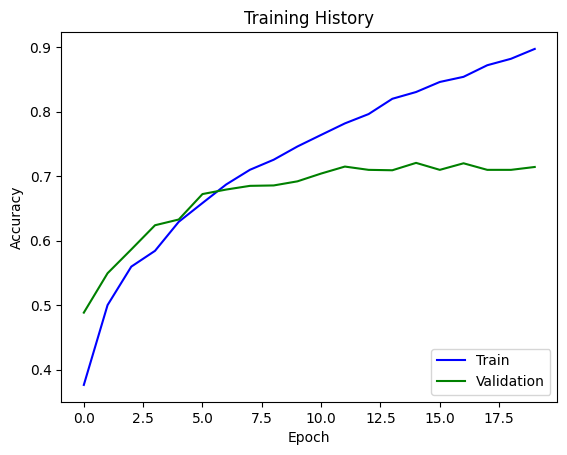

In [22]:
plt.plot(my_summary.history['accuracy'], c="b")
plt.plot(my_summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

#### 1.7. Testing: 

In [23]:
ACC = my_model.evaluate(X_test, y_test, verbose=0)[1]    
print("Test Accuracy : {}".format(np.round(ACC,3)))

Test Accuracy : 0.704
